In [1]:
from spyral_utils.plot import CutHandler, Histogrammer
from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.particle_id import serialize_particle_id, ParticleID
from spyral.core.constants import DEG2RAD
from spyral.core.run_stacks import form_run_string

import polars as pl
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib widget

RAD2DEG = 1.0/DEG2RAD

In [2]:
# Load config
workspace_path = Path("/Volumes/researchEXT/O16/O16_spyral_analysis")
estimation_result_path = workspace_path / "Estimation"

# Set the run range (inclusive)
run_min = 53
run_max = 169

# IC gate
ic_min_val = -10
ic_max_val = 4095.0

# Nucleus map
nuclear_map = NuclearDataMap()

In [3]:
# Set PID cut parameters for nucleus that will be gated on
pid_name = "alpha_cut" # name given to PID
pid_z = 2 # atomic number
pid_a = 4 # mass number
nucleus = nuclear_map.get_data(pid_z, pid_a)
pid_x_axis = "shifted_dEdx" # This is the PID x-axis, matching a column name in the estimation dataframe
pid_y_axis = "brho" # This is the PID y-axis, matching a column name in the estimation dataframe
pid_path = Path("/Users/mahesh/Desktop/academics/research/e20009_analysis/solver_particle_16O.json") # Path to which we will write our PID


In [4]:
# Make utility objects for plotting and making cuts
grammer = Histogrammer()
handler = CutHandler()

In [5]:
# Create histograms
grammer.add_hist2d("particle_id", (600, 600), ((-10.0, 1.2e4), (-0.1, 3.0)))# Plot of dEdx vs. Brho (particle ID)
grammer.add_hist1d("ion_chamber", 4095, (0, 4095.0)) # Plot of ion chamber (beam ID)
grammer.add_hist1d("dedx_hist", 80, (0, 10000)) # Plot of ion chamber (beam ID)
grammer.add_hist2d("kinematics", (720, 400), ((0.0, 180.0), (0.0, 3.0))) # Plot of polar angle vs. Brho (kinematics)

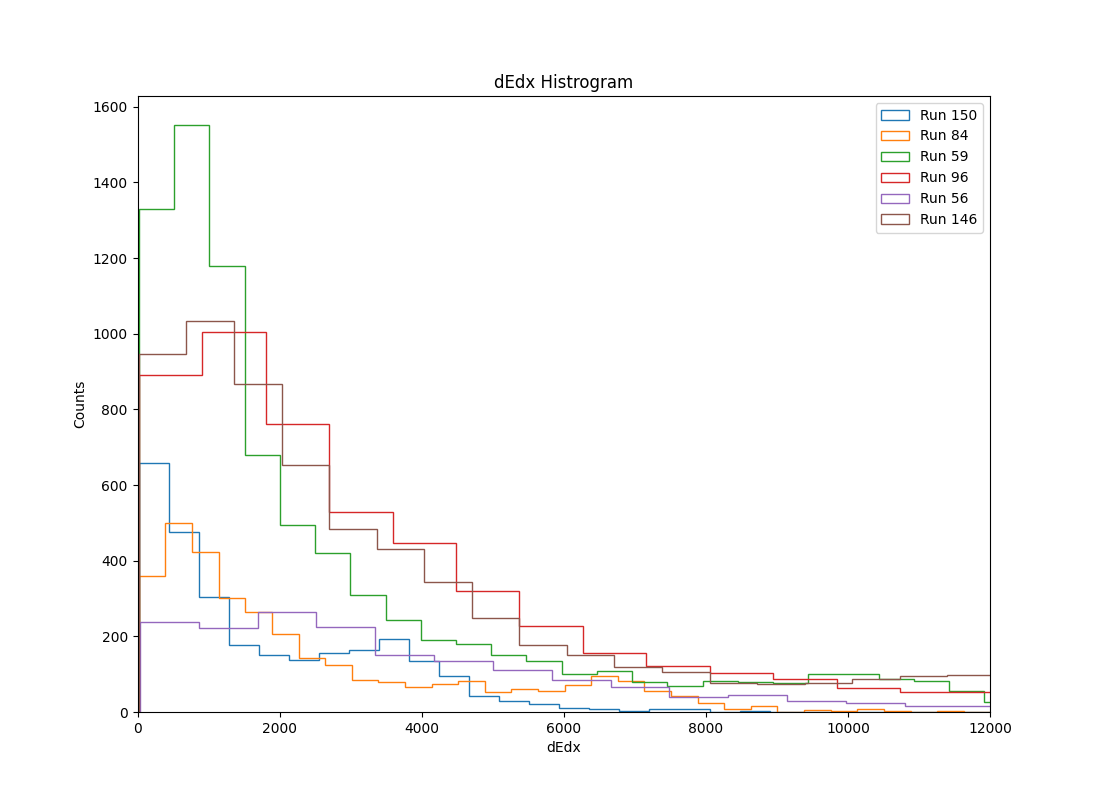

In [6]:
# Fill histograms
from lmfit.models import GaussianModel

run_range  = [150,84,59,96,56,146] #,84,59,96,56

# for run in run_range: #run_min,run_max+1
#     run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
#     if not run_path.exists():
#         continue
#     df = pl.scan_parquet(run_path)

#     # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
#     df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
#     df = df.collect()

#     grammer.fill_hist2d('particle_id', df.select('dEdx').to_numpy(), df.select('brho').to_numpy()) # Use your custom axes
#     grammer.fill_hist2d('kinematics', df.select('polar').to_numpy() * RAD2DEG, df.select('brho').to_numpy())
#     grammer.fill_hist1d('ion_chamber', df.unique(subset=['event']).select('ic_amplitude').to_numpy())
#     grammer.fill_hist1d('dedx_hist', df.unique(subset=['event']).select('dEdx').to_numpy())

cmap = plt.get_cmap("tab10")
#total_runs = max(run_range) - min(run_range) + 1

fig, ax = plt.subplots(figsize=(11, 8))

for idx, run in enumerate(run_range): #
    run_path = estimation_result_path / f"{form_run_string(int(run))}.parquet"
    if not run_path.exists():
        continue
    
    df = pl.scan_parquet(run_path)
    df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
    df = df.collect()
    dEdx = df.select('dEdx').to_numpy()
    brho = df.select('brho').to_numpy()
    color = cmap(idx)
    # ax.scatter(dEdx, brho, s=1, color=color, label=f"Run {run}", alpha=0.7)
    # dEdx_range = dEdx[(dEdx <= 2000)]
    counts, bin_edges, _ = plt.hist(dEdx, bins=50, color=color,histtype='step',edgecolor=color, label=f"Run {run}")
    # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # gmodel = GaussianModel()
    # params = gmodel.make_params(amplitude=np.max(counts) * np.sqrt(2 * np.pi) * np.std(dEdx_range),
    #                            center=np.mean(dEdx_range),
    #                            sigma=np.std(dEdx_range))
    # result = gmodel.fit(counts, params, x=bin_centers)
    # plt.plot(bin_centers, result.best_fit, 'r-', label='Gaussian Fit')
    # plt.axvline(x=result.params["center"].value, color=color, linestyle='--', label=f'Gaussian Center = {result.params["center"].value}')

# ax.set_title("Particle ID Distribution (scatter per run)")
# ax.set_xlabel("dE/dx (arb.)")
# ax.set_ylabel("B$\\rho$ (Tm)")
# ax.set_ylim(0, 1.2)
# ax.set_xlim(0,12000)
# ax.legend(markerscale=5)
plt.title("dEdx Histrogram")
plt.xlabel("dEdx")
plt.ylabel("Counts")
plt.xlim(0,12000)
plt.legend()
plt.show()

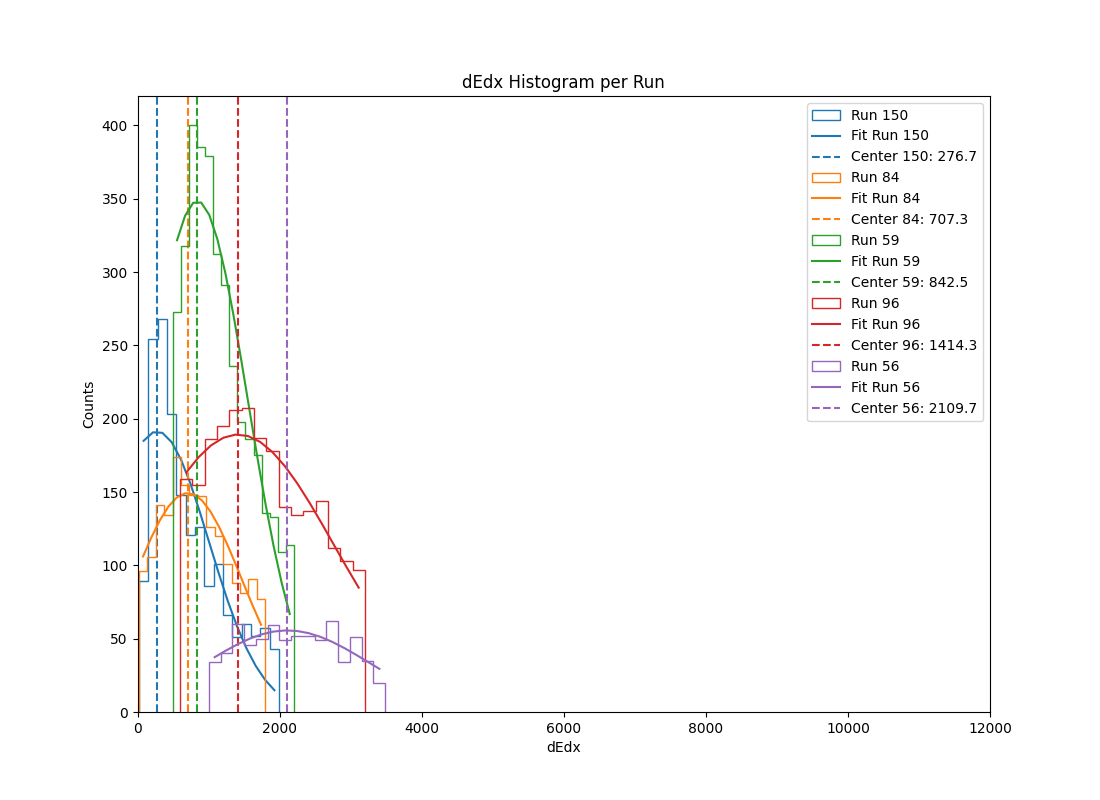

In [7]:
from lmfit.models import GaussianModel

run_range = [150,84,59,96,56]
dedx_fit_ranges = {
    150: (0, 2000),
    84: (0, 1800),
    59: (500, 2200),
    96: (600, 3200),
    56: (1000, 3500),
}

fig, ax = plt.subplots(figsize=(11, 8))
cmap = plt.get_cmap("tab10")

for idx, run in enumerate(run_range):
    run_path = estimation_result_path / f"{form_run_string(int(run))}.parquet"
    if not run_path.exists():
        continue

    df = pl.scan_parquet(run_path)
    df = df.filter((pl.col("ic_amplitude") > ic_min_val) & (pl.col("ic_amplitude") < ic_max_val))
    df = df.collect()

    dEdx = df.select("dEdx").to_numpy().flatten()
    brho = df.select("brho").to_numpy().flatten()
    color = cmap(idx)

    # Use per-run dEdx fit range if available
    if run in dedx_fit_ranges:
        dmin, dmax = dedx_fit_ranges[run]
        dEdx_range = dEdx[(dEdx >= dmin) & (dEdx <= dmax)]
    else:
        dEdx_range = dEdx[(dEdx <= 2000)]  # fallback

    # Histogram and Gaussian fit
    counts, bin_edges, _ = plt.hist(dEdx_range, bins=15, color=color, histtype="step", edgecolor=color, label=f"Run {run}")
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    if len(dEdx_range) > 0 and np.any(counts):
        gmodel = GaussianModel()
        params = gmodel.make_params(
            amplitude=np.max(counts) * np.sqrt(2 * np.pi) * np.std(dEdx_range),
            center=np.mean(dEdx_range),
            sigma=np.std(dEdx_range),
        )
        result = gmodel.fit(counts, params, x=bin_centers)

        plt.plot(bin_centers, result.best_fit, color=color, linestyle="-", label=f"Fit Run {run}")
        plt.axvline(result.params["center"].value, color=color, linestyle="--", label=f"Center {run}: {result.params['center'].value:.1f}")

plt.title("dEdx Histogram per Run")
plt.xlabel("dEdx")
plt.ylabel("Counts")
plt.xlim(0, 12000)
plt.legend()
plt.show()

In [123]:
gain_shift_groups = {
    1: [150,151,152],
    2: [83,84,85,86,87,88,89,105,108,109,116,117,141,142,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169],
    3: [53,59,60,61,62,64,65,66,67,68,70,71,72,73,74,106,110,112,113,118,119,120,121,122,123,132,143,145],
    4: [94,96,98,99,100,101,102,103,104,133,134,135,136,137,139,140],
    5: [54,55,56,58,78,97],
    6: [63,77,90,91,92,111,114,124,125,126,127,130,144,146,148],
}

gain_shift_eloss = {
1: 1.82,
2: 1.45,
3: 1,
4: 0.70,
5: 0.51,
6: 0.85,
}

# gain_shift_eloss = {
# 1: 800,
# 2: 350.2,
# 3: 0,
# 4: -850,
# 5: -1266,
# 6: -200,
# }

#371
# gain_shift_eloss = {
# 1: 0,
# 2: -430.6,
# 3: -565.8,
# 4: -1137.6,
# 5: -1833,
# }

gain_shift_assign = {}


for key,value in zip(gain_shift_groups.keys(),gain_shift_groups.values()):
   for j in value:
      gain_shift_assign[j] = key

print(gain_shift_assign)

{150: 1, 151: 1, 152: 1, 83: 2, 84: 2, 85: 2, 86: 2, 87: 2, 88: 2, 89: 2, 105: 2, 108: 2, 109: 2, 116: 2, 117: 2, 141: 2, 142: 2, 153: 2, 154: 2, 155: 2, 156: 2, 157: 2, 158: 2, 159: 2, 160: 2, 161: 2, 162: 2, 163: 2, 164: 2, 165: 2, 166: 2, 167: 2, 168: 2, 169: 2, 53: 3, 59: 3, 60: 3, 61: 3, 62: 3, 64: 3, 65: 3, 66: 3, 67: 3, 68: 3, 70: 3, 71: 3, 72: 3, 73: 3, 74: 3, 106: 3, 110: 3, 112: 3, 113: 3, 118: 3, 119: 3, 120: 3, 121: 3, 122: 3, 123: 3, 132: 3, 143: 3, 145: 3, 94: 4, 96: 4, 98: 4, 99: 4, 100: 4, 101: 4, 102: 4, 103: 4, 104: 4, 133: 4, 134: 4, 135: 4, 136: 4, 137: 4, 139: 4, 140: 4, 54: 5, 55: 5, 56: 5, 58: 5, 78: 5, 97: 5, 63: 6, 77: 6, 90: 6, 91: 6, 92: 6, 111: 6, 114: 6, 124: 6, 125: 6, 126: 6, 127: 6, 130: 6, 144: 6, 146: 6, 148: 6}


In [124]:
import pandas as pd

for run in gain_shift_assign.keys(): #sorted_gain_shift.keys()
    run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
    if not run_path.exists():
        continue
    df = pd.read_parquet(run_path)
    group = gain_shift_assign[run]
    shift = gain_shift_eloss[group]
    df["shifted_dEdx"] = df["dEdx"] * shift 
    shifted_file_path = "/Volumes/researchEXT/O16/shifted_dedx/"
    df.to_parquet(f"{shifted_file_path+form_run_string(run)}.parquet", index=False)
    
    



    

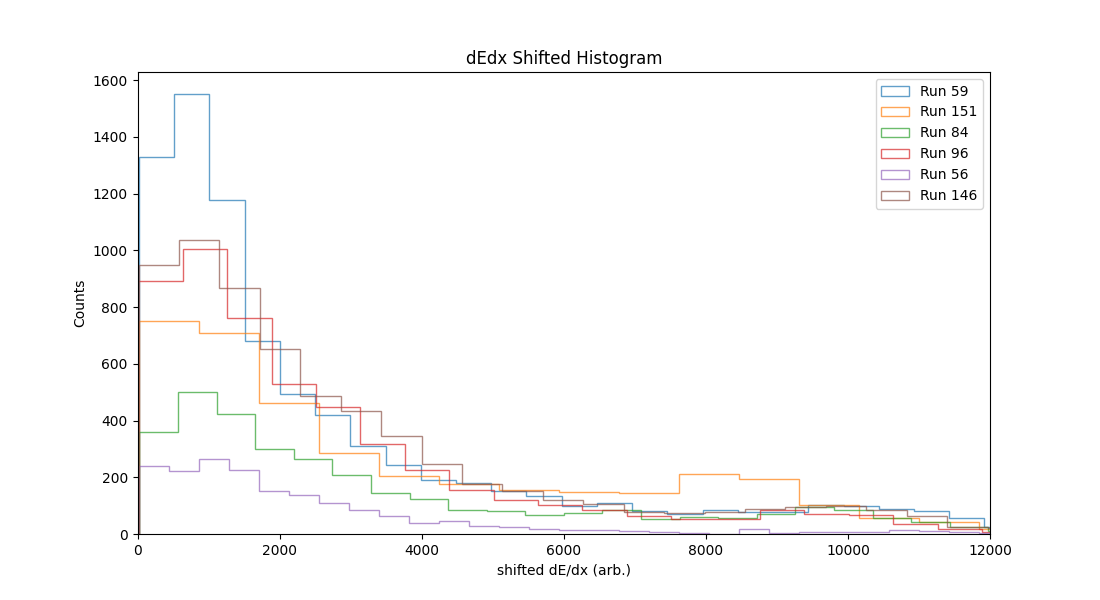

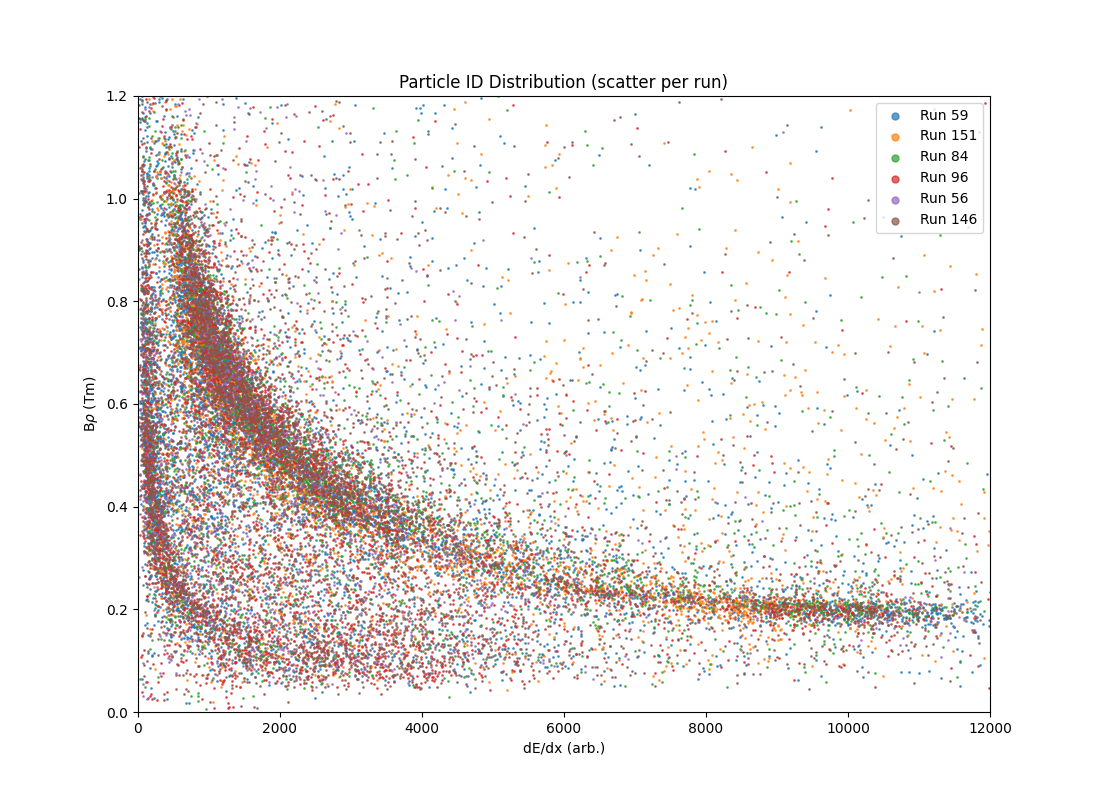

In [127]:
cmap = plt.get_cmap("tab10")
run_range = [59,151,84,96,56,146]# 151,84,96,56,146
fig_scatter, ax_scatter = plt.subplots(figsize=(11, 8))

for idx, run in enumerate(run_range):
    shifted_file_path = "/Volumes/researchEXT/O16/shifted_dedx/"
    run_path = f"{shifted_file_path + form_run_string(run)}.parquet"
    if not os.path.exists(run_path):
        continue

    df = pl.scan_parquet(run_path)
    df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val)).collect()

    dEdx = df.select('shifted_dEdx').to_numpy().flatten()
    brho = df.select('brho').to_numpy().flatten()
    color = cmap(idx)

    ax_scatter.scatter(dEdx, brho, s=1, color=color, label=f"Run {run}", alpha=0.7)

ax_scatter.set_title("Particle ID Distribution (scatter per run)")
ax_scatter.set_xlabel("dE/dx (arb.)")
ax_scatter.set_ylabel("B$\\rho$ (Tm)")
ax_scatter.set_xlim(0, 12000)
ax_scatter.set_ylim(0, 1.2)
ax_scatter.legend(markerscale=5)


fig_hist, ax_hist = plt.subplots(figsize=(11, 6))

for idx, run in enumerate(run_range):
    shifted_file_path = "/Volumes/researchEXT/O16/shifted_dedx/"
    run_path = f"{shifted_file_path + form_run_string(run)}.parquet"
    if not os.path.exists(run_path):
        continue

    df = pl.scan_parquet(run_path)
    df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val)).collect()

    dEdx = df.select('shifted_dEdx').to_numpy().flatten()
    color = cmap(idx)

    ax_hist.hist(dEdx, bins=50, color=color, histtype='step', edgecolor=color, label=f"Run {run}", alpha=0.7)

ax_hist.set_title("dEdx Shifted Histogram")
ax_hist.set_xlabel("shifted dE/dx (arb.)")
ax_hist.set_ylabel("Counts")
ax_hist.set_xlim(0, 12000)
ax_hist.legend()

plt.show()

In [128]:


# run_range  = [150,84,59,96,56]
for run in range(run_min,run_max+1): #run_min,run_max+1
    shifted_file_path = "/Volumes/researchEXT/O16/shifted_dedx/"
    run_path = f"{shifted_file_path+form_run_string(run)}.parquet"
    if not os.path.exists(run_path):
        continue
    df = pl.scan_parquet(run_path)

    # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
    df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
    df = df.collect()

    grammer.fill_hist2d('particle_id', df.select('shifted_dEdx').to_numpy(), df.select('brho').to_numpy()) # Use your custom axes
    # grammer.fill_hist2d('kinematics', df.select('polar').to_numpy() * RAD2DEG, df.select('brho').to_numpy())
    # grammer.fill_hist1d('ion_chamber', df.unique(subset=['event']).select('ic_amplitude').to_numpy())
    grammer.fill_hist1d('dedx_hist', df.unique(subset=['event']).select('shifted_dEdx').to_numpy())

In [12]:
# # Plot IC
# ic = grammer.get_hist1d("ion_chamber")
# fig, ax = plt.subplots(1,1)
# ax.stairs(ic.counts, edges=ic.bins)
# ax.set_title("Ion Chamber")
# ax.set_xlabel("Amplitude (arb.)")
# ax.set_ylabel("Counts")
# fig.set_figwidth(8.0)

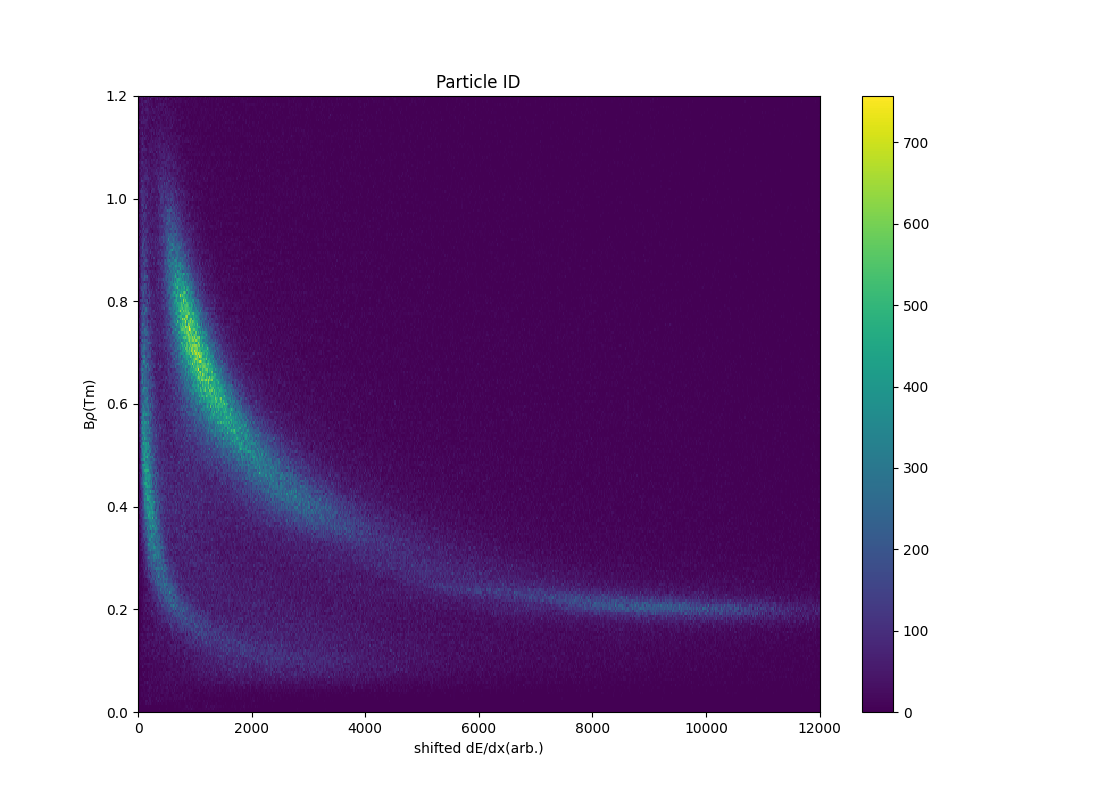

In [130]:


# Plot PID and draw gate by clicking points on plot
pid_hist = grammer.get_hist2d("particle_id")
fig, ax = plt.subplots(1,1)
_ = PolygonSelector(ax, handler.mpl_on_select)
mesh = ax.pcolormesh(pid_hist.x_bins, pid_hist.y_bins, pid_hist.counts)
fig.colorbar(mesh, ax=ax)
ax.set_title("Particle ID")
ax.set_xlabel("shifted dE/dx(arb.)")
ax.set_ylabel("B$\\rho$(Tm)")
ax.set_ylim(0,1.2)
fig.set_figheight(8.0)
fig.set_figwidth(11.0)


In [14]:
df


event,cluster_index,cluster_label,ic_amplitude,ic_centroid,ic_integral,ic_multiplicity,ic_sca_centroid,ic_sca_multiplicity,vertex_x,vertex_y,vertex_z,center_x,center_y,center_z,polar,azimuthal,brho,dEdx,sqrt_dEdx,dE,arclength,direction,shifted_dEdx
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64
4822274,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-8.570611,-5.452873,904.606245,127.626649,81.288036,904.606245,0.774322,5.279484,0.69279,1372.560701,37.048086,92792.000001,67.605025,0,2347.078799
4822292,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.39367,-3.464796,392.491912,39.365066,-18.447043,392.491912,0.367674,4.274164,0.294685,6710.685805,81.918776,1.5222e6,226.836875,0,11475.272726
4822292,2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-10.883999,1.228973,364.17166,-73.98998,8.348559,364.17166,0.358616,1.458452,0.542822,1124.974733,33.540643,786471.281905,699.101286,0,1923.706793
4822298,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.110596,0.303083,769.244136,41.119739,-110.633626,769.244136,0.480884,3.497429,0.767575,621.370861,24.927312,120776.0,194.370235,0,1062.544172
4822298,2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.785639,12.690486,805.725992,16.250025,30.389541,805.725992,0.3552,5.792134,0.173133,4011.349553,63.335216,685778.280333,170.959492,0,6859.407736
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4869504,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-10.947924,3.530241,677.572685,-22.852079,7.368429,677.572685,0.103223,1.258896,0.36416,2726.564999,52.21652,592934.0,217.465566,0,4662.426148
4869507,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.480602,-0.421269,1000.454193,342.071063,56.739338,1000.454193,1.774242,4.87679,1.069847,3487.6466,59.0563,84553.841796,24.24381,1,5963.875686
4869507,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.031091,-3.603843,733.203029,0.66051,-75.02741,733.203029,0.499445,3.150405,0.447404,1642.377431,40.526256,423617.0,257.929141,0,2808.465407


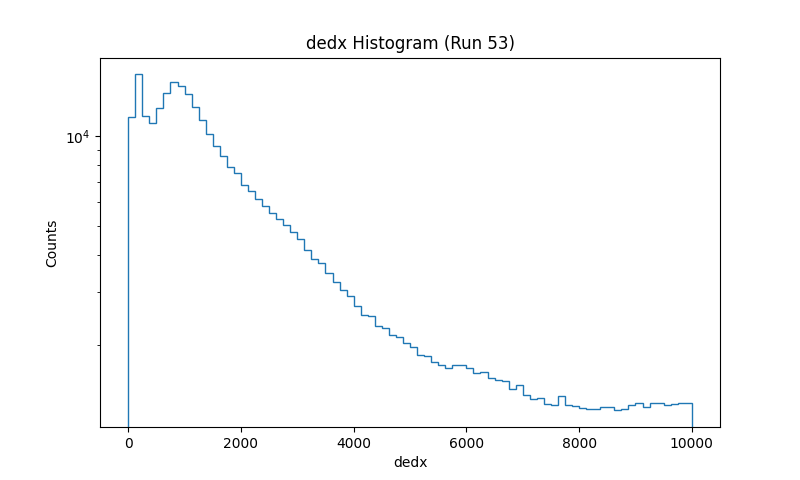

In [15]:
ic = grammer.get_hist1d("dedx_hist")
fig, ax = plt.subplots(1,1)
ax.stairs(ic.counts, edges=ic.bins)
ax.set_title(f"dedx Histogram (Run {run_min})")
ax.set_xlabel("dedx")
ax.set_ylabel("Counts") 
ax.set_yscale('log')
fig.set_figwidth(8.0)

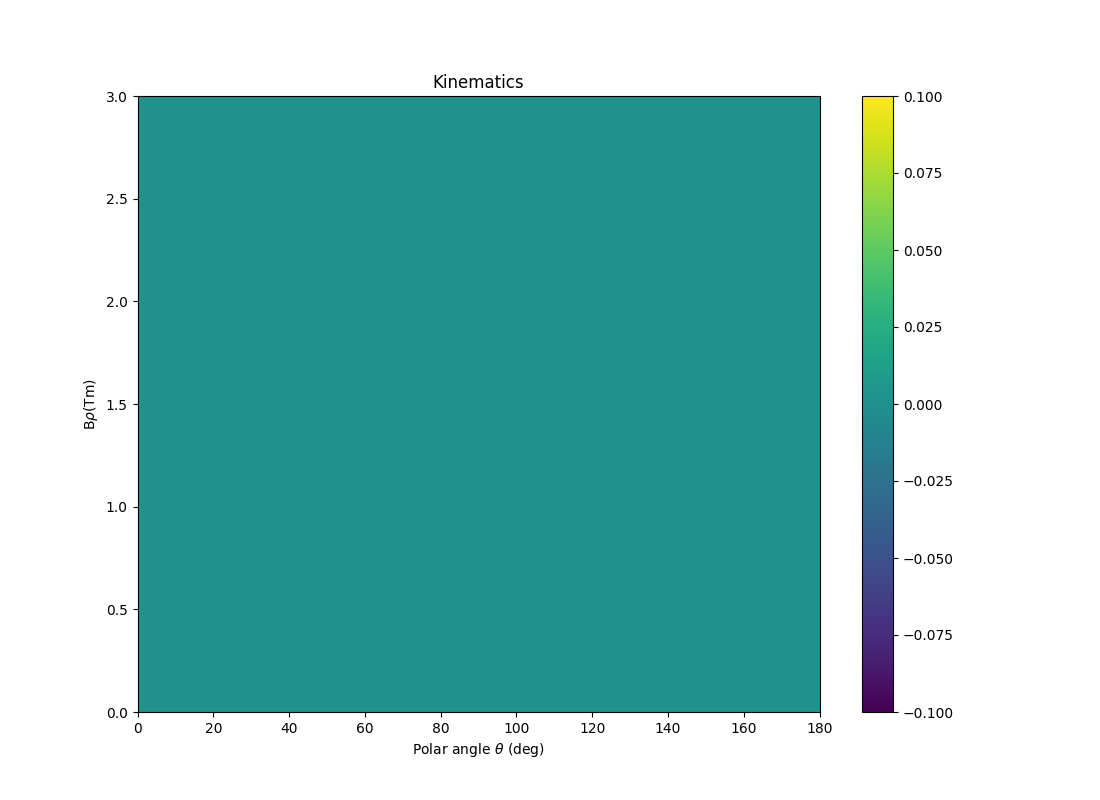

In [16]:
# Plot estimated kinematics
kine = grammer.get_hist2d("kinematics")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(kine.x_bins, kine.y_bins, kine.counts)
fig.colorbar(mesh, ax=ax)
ax.set_title("Kinematics")
ax.set_xlabel("Polar angle $\\theta$ (deg)")
ax.set_ylabel("B$\\rho$(Tm)")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)

In [17]:
# # Save PID
# # If you've made multiple cuts, you'll want to change the name used here. Cuts are automatically named in the order they were made (first cut is cut_0, second cut_1, etc.)
# cut = handler.cuts["cut_0"]
# cut.name = pid_name
# cut.x_axis = pid_x_axis # specify our axes
# cut.y_axis = pid_y_axis
# pid = ParticleID(cut, nucleus)
# # Save our pid
# serialize_particle_id(pid_path, pid)


In [18]:
# # Make and fill kinematics and PID histograms gated on user input gate
# grammer.add_hist2d("particle_id_gated", (400, 400), ((-10.0, 100.0), (-0.1, 2.5))) # Plot of dEdx vs. Brho (particle ID), gated on PID
# grammer.add_hist2d("kinematics_gated", (720, 400), ((0.0, 180.0), (0.0, 3.0))) # Plot of polar angle vs. Brho (kinematics), gated on PID

# for run in range(run_min, run_max+1):
#     run_path = estimation_result_path / f"{form_run_string(run)}.parquet"
#     if not run_path.exists():
#         continue
#     df = pl.scan_parquet(run_path)

#     df = df.filter(pl.struct([pid_x_axis, pid_y_axis]).map_batches(pid.cut.is_cols_inside)) # apply PID
#     # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
#     df = df.filter((pl.col('ic_amplitude') > ic_min_val) & (pl.col('ic_amplitude') < ic_max_val))
#     df = df.collect()

#     grammer.fill_hist2d('particle_id_gated', df.select(pid_x_axis).to_numpy(), df.select(pid_y_axis).to_numpy())
#     grammer.fill_hist2d('kinematics_gated', df.select('polar').to_numpy() * RAD2DEG, df.select('brho').to_numpy())

In [19]:
# # Plot gated PID
# pid_gated = grammer.get_hist2d("particle_id_gated")
# fig, ax = plt.subplots(1,1)
# mesh = ax.pcolormesh(pid_gated.x_bins, pid_gated.y_bins, pid_gated.counts)
# fig.colorbar(mesh, ax=ax)
# ax.set_title("Particle ID Gated")
# ax.set_xlabel(f"{pid_x_axis} Column")
# ax.set_ylabel(f"{pid_y_axis} Column")
# fig.set_figheight(8.0)
# fig.set_figwidth(11.0)

In [20]:
# # Plot gated kinematics
# kine_gated = grammer.get_hist2d("kinematics_gated")
# fig, ax = plt.subplots(1,1)
# mesh = ax.pcolormesh(kine_gated.x_bins, kine_gated.y_bins, kine_gated.counts)
# fig.colorbar(mesh, ax=ax)
# ax.set_title("Kinematics Gated")
# ax.set_xlabel("Polar angle $\\theta$ (deg)")
# ax.set_ylabel("B$\\rho$(Tm)")
# fig.set_figheight(8.0)
# fig.set_figwidth(11.0)